# EE 384N homework 2: solutions
by I. Escobar

In [1]:
import pandas as pd
from numpy import angle, log10, meshgrid, arange,\
                pi, linspace, array, nanargmin
from cmath import sin, cos, tan, acos, atan, sqrt
import matplotlib.pyplot as plt
import warnings, os

warnings.simplefilter('ignore')
os.environ['PYTHONWARNOINGS'] = 'ignore'

## Solution 1

We assume a fluid-fluid interface for parts **a** and **b** and a fluid-solid interface for part **c**. To calculate angles of interest, we take advantage of Snell's Law and algebraic manipulations of it.

First we load in ocean bottom properties.

In [2]:
df=pd.read_csv('./obProperties.csv')
df= df.set_index('name')
df

,c,alpha,rho,cs,alphas,rhoSI
name,,,,,,
water,1500.0,0.0,1.0,0.0,0.0,1000.0
clay,1490.0,0.1,1.5,0.0,0.0,1500.0
silt,1575.0,1.0,1.7,0.0,0.0,1700.0
sand,1650.0,0.8,1.9,100.0,2.5,1900.0
gravel,1800.0,0.6,2.0,200.0,1.5,2000.0
moraine,1950.0,0.4,2.1,600.0,1.0,2100.0
chalk,2400.0,0.2,2.2,1000.0,0.5,2200.0
limestone,3000.0,0.1,2.4,1500.0,0.2,2400.0
basalt,5250.0,0.1,2.7,2500.0,0.2,2700.0


We rearrange Snell's law of refraction to calculate $\theta_2$.

\begin{align}
    k_1 \cos\theta_1 &= k_2 \cos\theta_2, \\
    \cos\theta_2 &= \frac{k_1}{k_2} \cos\theta_1, \\
    (k &= \frac{\omega}{c}),\\
    \cos\theta_2 &= \frac{c_2}{c_1} \cos\theta_1, \\
    \theta_2 &= \cos^{-1}\Big(\frac{c_2}{c_1} \cos\theta_1\Big).
\end{align}

We solve for the lossy plane wave relfection coefficient, $R$, as a function of effective impedances, $Z$. $R$ is stored as a complex number array using the **cmath** library.

 A lossy $R$ is a function of complex sound speed. Sound speeds from the table are converted to complex numbers, $c = c_r - ic_i$ where
 
$
c_i = \frac{\alpha}{\omega} c_r^2.
$

Here $\alpha$ is attenuation in Np/m. We are given $\alpha_\lambda$ which has units in dB/$\lambda$. To convert to Np/m, we use eq'n (1.46) from *COA_chpt1.pdf*:

\begin{align}
    \alpha &\approx \frac{\alpha_\lambda}{8.686\lambda}, \\
    (\lambda &= \frac{c}{f}),\\
    \alpha &\approx \frac{f\alpha_\lambda}{8.686c}.
\end{align}

Also remember $2\pi f = \omega$. Plugging into $c_i$ we find a frequency independent expression for lossy sound speed:

$
    c_i = \frac{\alpha_\lambda c_r}{17.372\pi}.
$

We consider materials with shear as a solid, and will treat that part as a fluid-solid interface. $Z$ for the solid incorporates both compressional and shear wave properties,

$
    Z_{tot} = Z_p\cos^2(2\theta_s)+Z_s\sin^2(\theta_s). 
$

The complex math package **cmath** does not support array computation (passing in vectors), so I'll have to loop through the functions each time I use them. They also only do comutations in radians so I'll manually convert to and from when appropriate. :(


http://hplgit.github.io/primer.html/doc/pub/formulas/._formulas-readable006.html

In [3]:
def Theta2 (c1, c2, theta1):
# Inputs:
#   c1 : sound speed of top fluid [m/s]
#   c2 : sound speed of bottom fluid [m/s]
#   theta1: grazing angle [deg] --> trig fxns use [rad]
# Returns:
#   theta2: transmission angle [deg]
    return acos(c2 * cos(pi*theta1/180.) / c1) * 180./pi

def cComplex(cr, alpha):
# Inputs:
#   cr : real part of sound speed [m/s]
#   alpha : attenuation [dB/lambda]
# Returns:
#   c : lossy sound speed [m/s] (complex)
    return complex( cr, -alpha*cr/(17.372*pi) )

def Z (rho,c,theta):
# Inputs:
#   rho : density [kg/m3]
#   c : sound speed [m/s]
#   theta: angle [deg] --> trig fxns use [rad]
# Returns:
#   Z: effective impedance of fluid [kg/m2/s]
    return rho*c/sin(pi*theta/180.)

def Ztot (rho,cs,thetas,cp,thetap):
# Inputs:
#   rho : density [kg/m3]
#   cs : shear sound speed [m/s]
#   thetas: shear angle [deg] --> trig fxns need [rad]
#   cp : compressional sound speed [m/s]
#   thetap: compressional angle [deg] --> trig fxns need [rad]
# Returns:
#   Ztot: effective impedance of solid [kg/m2/s]
    Zp = Z(rho,cp,thetap)
    Zs = Z(rho,cs,thetas)
    return Zp*cos(thetas*pi/90)**2 + Zs*sin(thetas*pi/90)**2

def R (data, mat1, theta1):
# Inputs:
#   data : pandas dataframe containing ocean bottom properties
#         c : sound speed [m/s]
#         rho : density [g/cm3]
#   mat1 : material name [string]
#   theta1 : grazing angle [deg]
# Returns:
#   rDict : Rayleigh's relfection coefficient [1] (dict)
    rDict = {}
    c1 = cComplex(data.loc[mat1,'c'], data.loc[mat1,'alpha'])
    df.loc[mat1,'cc']=c1
    rho1 = data.loc[mat1,'rho']
    
    for rho2,c2,name in \
    zip(data.loc[:,'rho'], data.loc[:,'c'], data.index):
        if(name != mat1):
            c2 = cComplex(c2, data.loc[name,'alpha'])
            cs = cComplex(data.loc[name,'cs'], data.loc[name,'alphas'])
            theta2 = []
            thetas = []
            z1 = []
            z2 = []
            for theta in theta1:
                theta2.append( Theta2(c1,c2,theta) )
                z1.append( Z(rho1,c1,theta) )
                if (cs == 0.):
                    z2.append( Z(rho2,c2,theta2[-1]) )
                else:
                    thetas.append( Theta2(c1,cs,theta) )                    
                    z2.append( Ztot(rho2,cs,thetas[-1],c2,theta2[-1]) )
            z1 = array(z1)
            z2 = array(z2)
            rDict.update( {name:(z2 - z1) / (z1 + z2)} )
            df.loc[name,'cc']=c2
            df.loc[name,'csc']=cs
    return rDict

def phaseDeg (arr):
# Inputs:
#   arr: array of complex data type
# Returns:
#   phase: array of phase of num [deg]
#          math.atan2(num.imag, num.real)
    ph = []
    for num in arr:
        ph.append( angle(num, deg=True) )
    ph = array(ph)
    return ph

def BL (rMag):
# Inputs:
#   rMag : magnitude of relfection coefficient [1]
# Returns:
#   bl : bottom loss [dB]
    return -20*log10(rMag)

In [4]:
theta1 = linspace(0.,90.,int(1e3),dtype=complex)
r = R(df,'water', theta1)

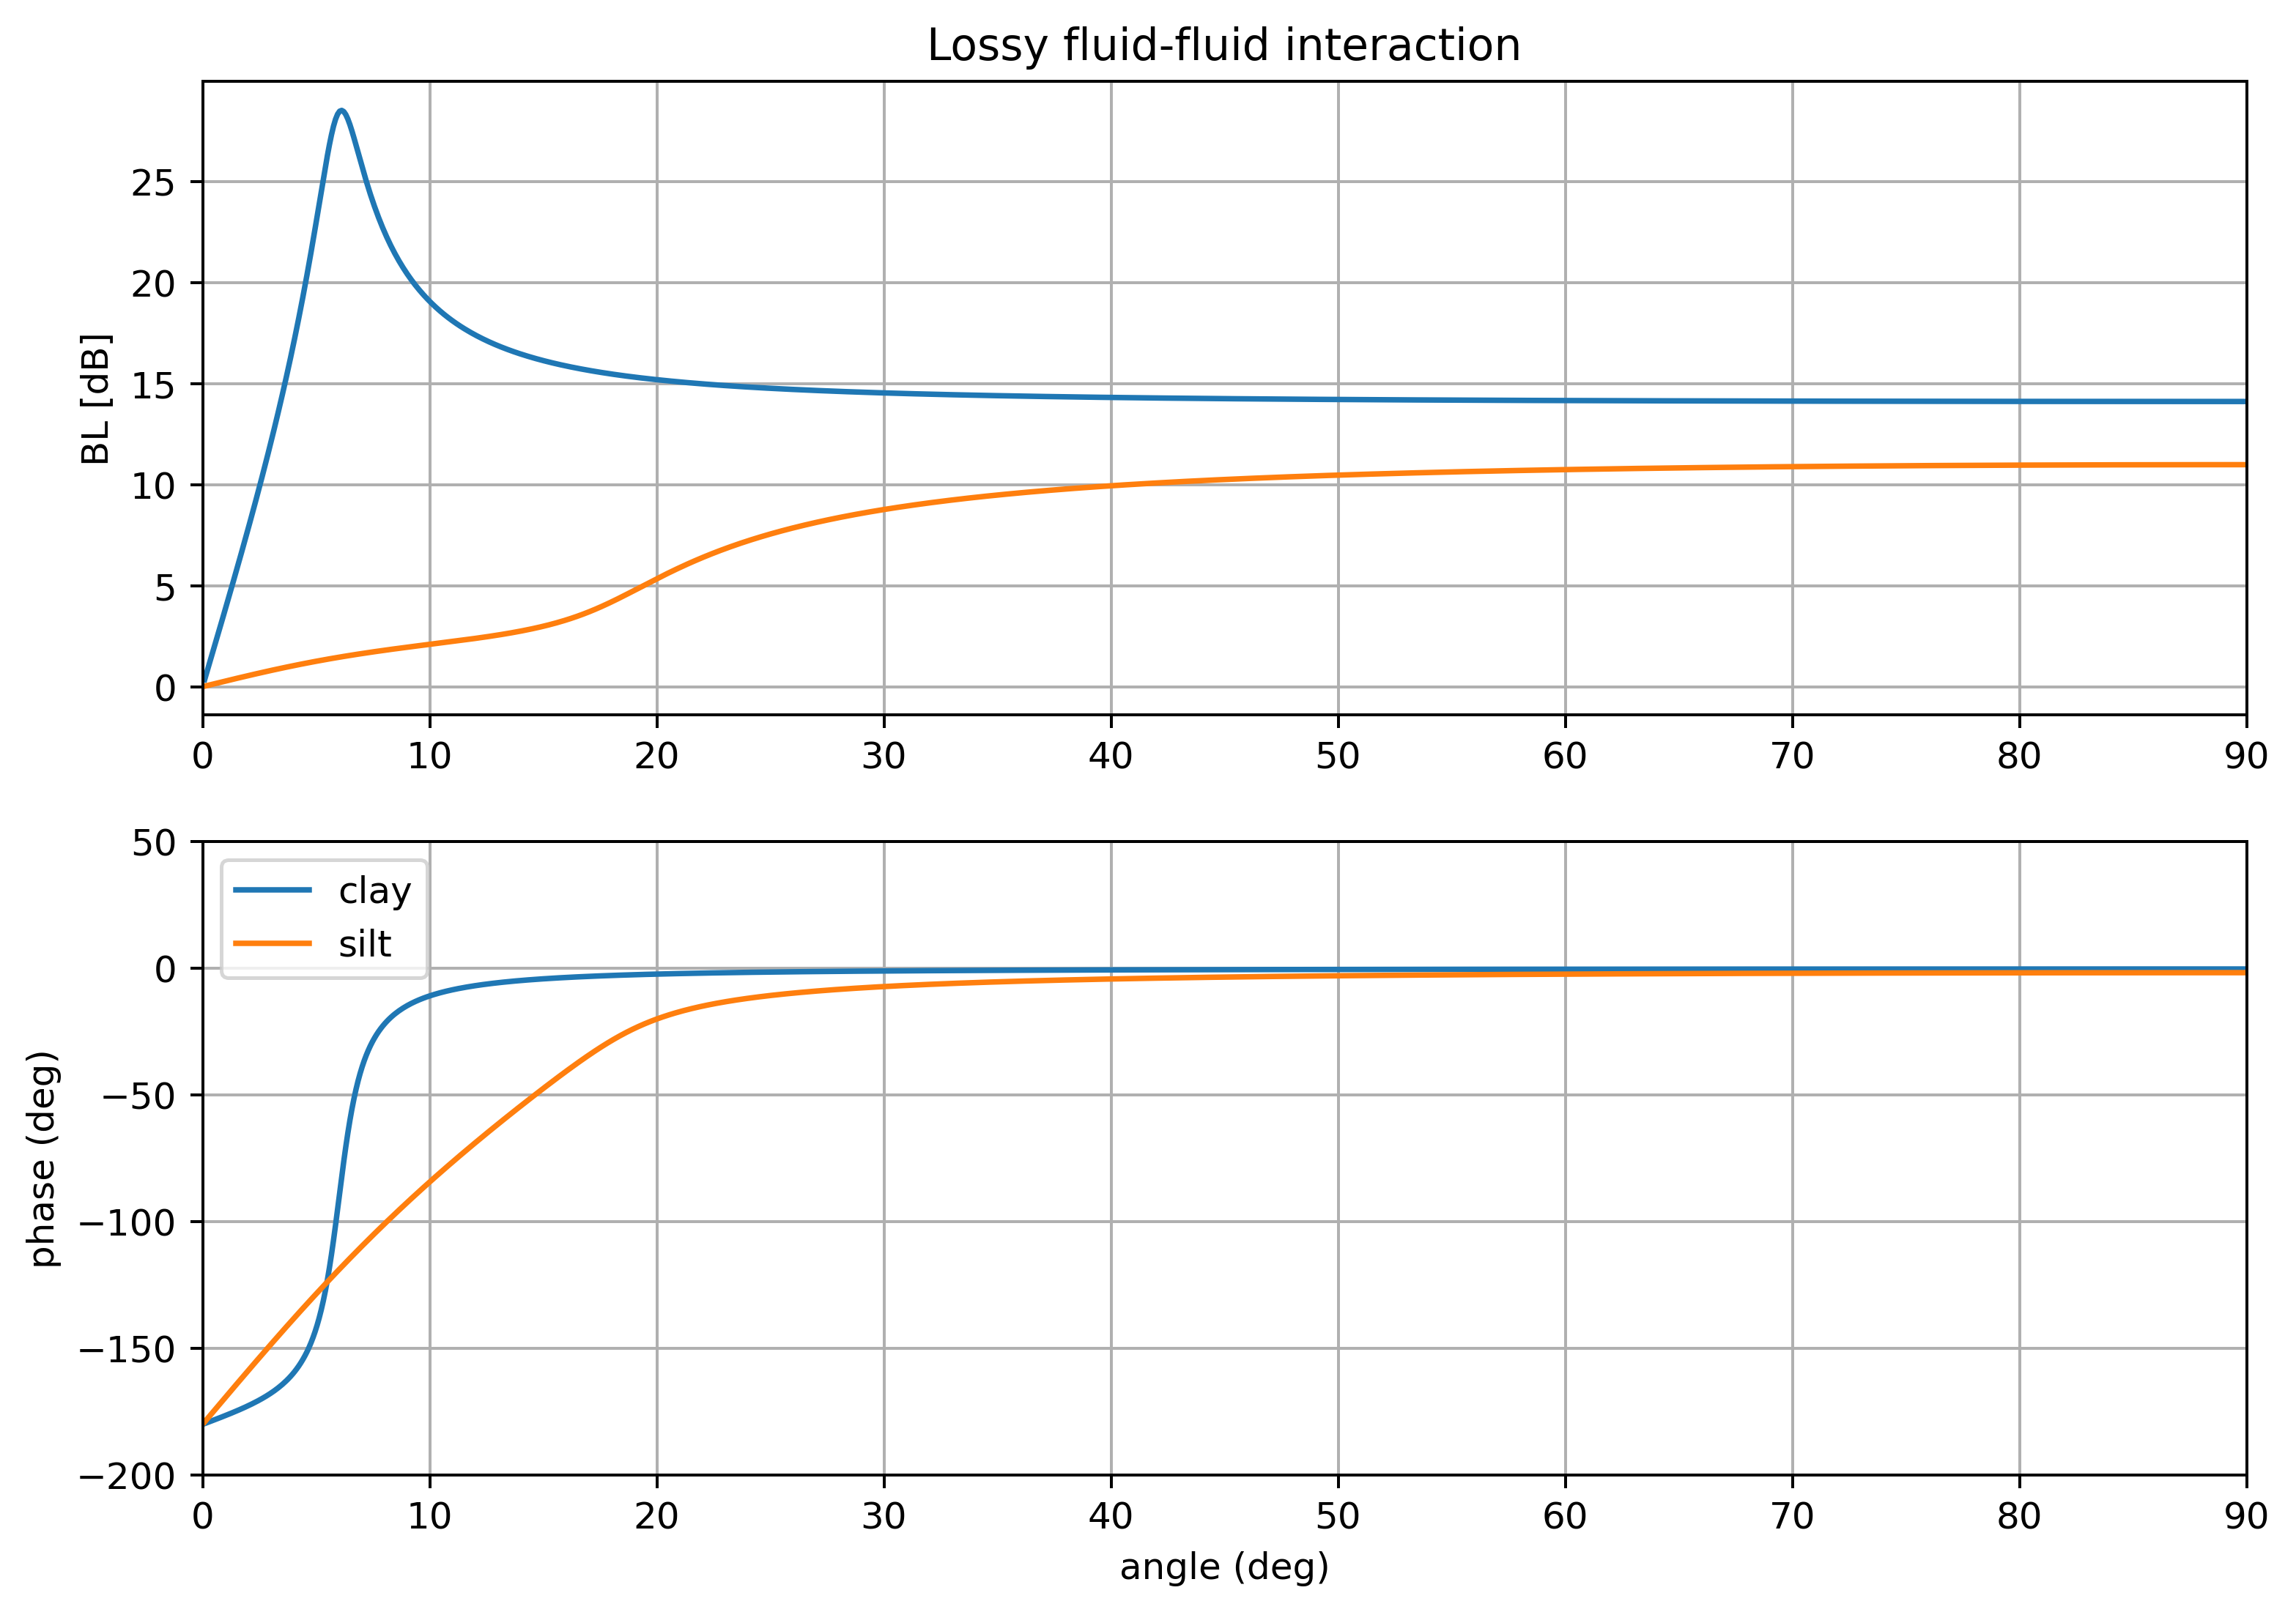

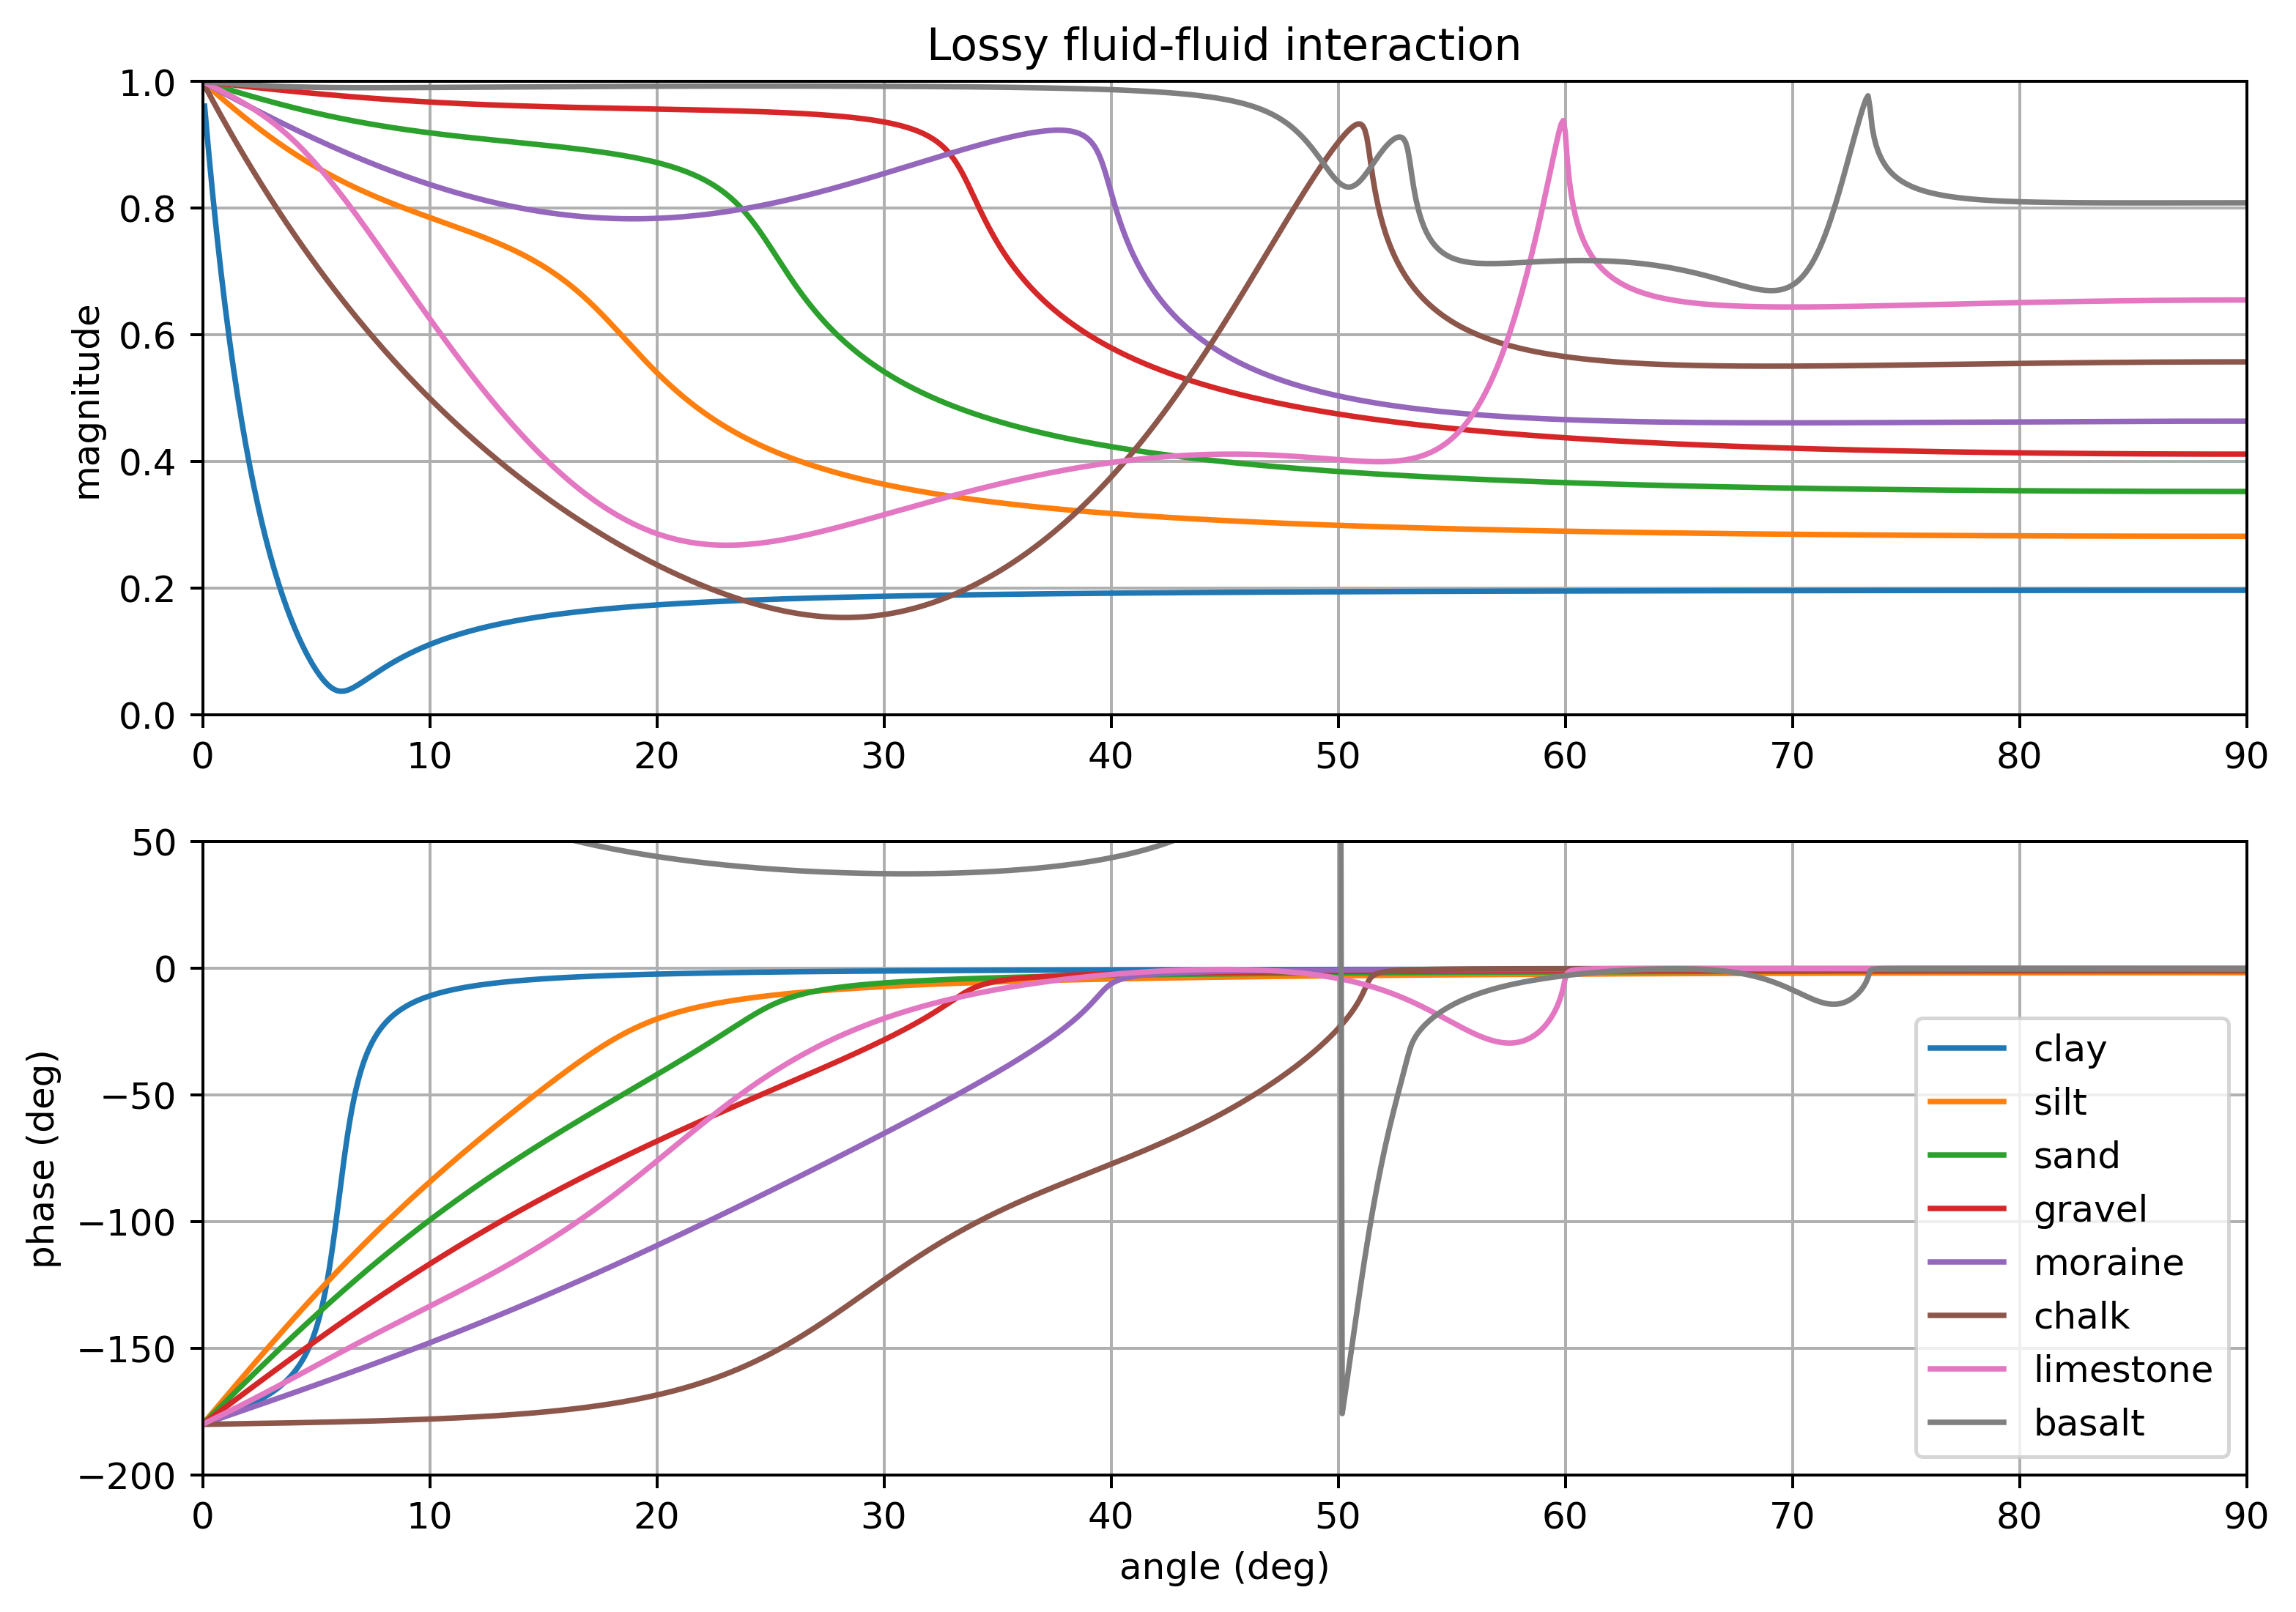

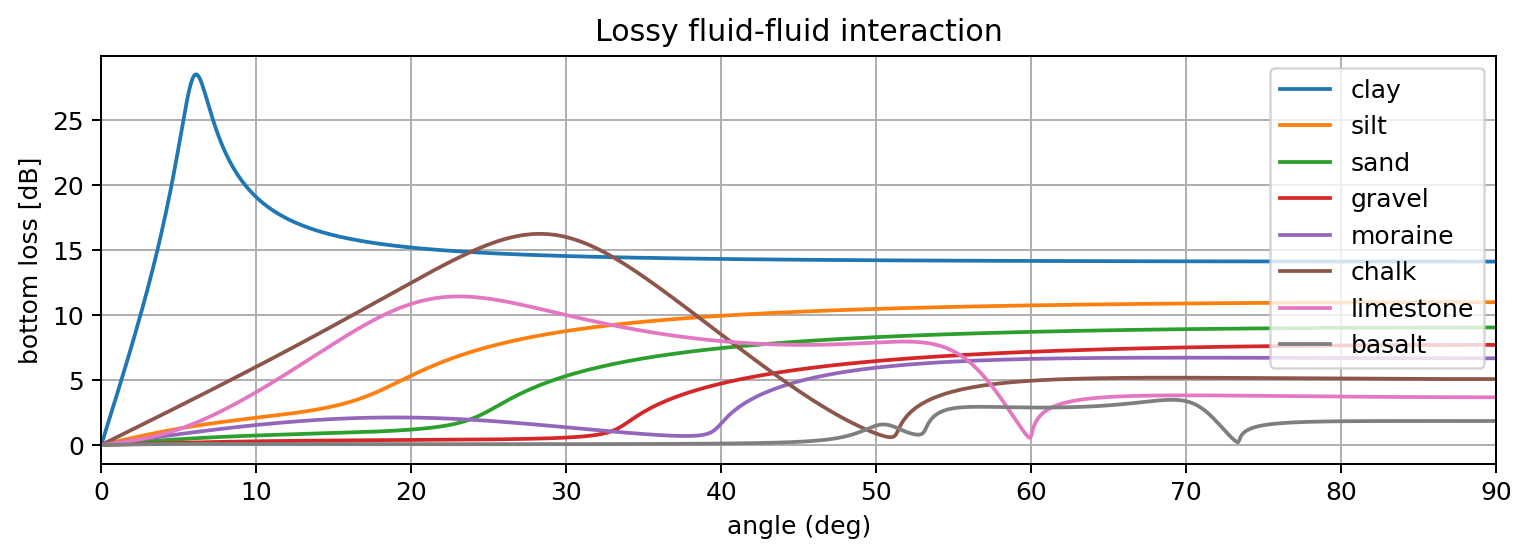

In [5]:
plt.figure(figsize=(10, 7), dpi=360)
plt.subplot(2,1,1)
for key in r:
        plt.plot(theta1.real, abs(r[key]), label=key)  
plt.xlim([0,90])
plt.ylim([0,1])
plt.ylabel('magnitude')
plt.grid()
plt.title('Lossy fluid-fluid interaction')

plt.subplot(2,1,2)
for key in r:
    plt.plot(theta1.real, phaseDeg(r[key]), label=key)  
plt.xlim([0,90])
plt.ylim([-200,50])
plt.xlabel('angle (deg)')
plt.ylabel('phase (deg)')
plt.grid()

plt.legend()
plt.show()

plt.figure(figsize=(10, 3), dpi=180)
for key in r:
        plt.plot(theta1.real, BL( abs(r[key]) ), label=key)  
plt.xlim([0,90])
plt.ylabel('bottom loss [dB]')
plt.xlabel('angle (deg)')
plt.grid()
plt.title('Lossy fluid-fluid interaction')

plt.legend(loc=1)
plt.show()

### a)

In ocean acoustics, there is only an angle of intromission when

$
    c_1>c_2, \text{and } \rho_1c_1<\rho_2c_2.
$

In [6]:
def intromissionCheck (mat1, data):
# Inputs:
#   mat1: material name
#   data : pandas dataframe containing ocean bottom properties
#         c : sound speed [m/s]
#         rho : density [g/cm3]
# Returns:
#   statement with angle of intromission
    c1 = data.loc[mat1,'cc']
    rho1 = data.loc[mat1,'rhoSI']
    
    for rho2,c2,name in \
    zip(data.loc[:,'rhoSI'], data.loc[:,'cc'], data.index):
        if (c1 > c2 and rho1*c1 < rho2*c2):
            print('%s has an angle of intromission' %name)
            print('theta_I is', thetaI(c1,rho1,c2,rho2))
    return None

def thetaI (c1,r1, c2,r2):
# Inputs:
#   c1 : sound speed of top material [m/s] 
#   rho : density of top material [g/cm3]
#   c2 : sound speed of bottom material [m/s]
#   rho : density of bottom material [g/cm3]
# Returns:
#   intromission angle : [deg]
    return atan( sqrt( (1-(c2/c1)**2)/((r2*c2/r1/c1)**2-1) ) ) * 180/pi

In [7]:
intromissionCheck('water', df)

print('Angle at magnitude minimum:',\
      theta1[nanargmin( abs(r['clay']) )] )

clay has an angle of intromission
theta_I is (6.010716795188862+0.8172379847128473j)
Angle at magnitude minimum: (6.126126126126126+0j)


Searching through each of the materials, we find that clay is the only material that has an angle of intromission. This is because clay has low sound speed and high density when compared with water. 

The reflection coefficient of clay reaches zero at a grazing angle of $6.011^\circ$. Here, the acoustic energy from water completely transfers to the clay layer. 

$
    \theta_I = 6.011^\circ
$

### b)

The critical angle exists only when
$
    c_1<c_2.
$

In [8]:
def criticalangleCheck (mat1, data):
# Inputs:
#   mat1: material name
#   data : pandas dataframe containing ocean bottom properties
#         c : sound speed [m/s]
#         rho : density [g/cm3]
# Returns:
#   statement with critical angle
    c1 = data.loc[mat1,'cc']
    rho1 = data.loc[mat1,'rhoSI']
    
    for rho2,c2,name in \
    zip(data.loc[:,'rhoSI'], data.loc[:,'cc'], data.index):
        if (c1 < c2):
            print('%s has a critical angle' %name)
            print('\ttheta_c is', thetac(c1,c2))
    return None

def thetac (c1,c2):
# Inputs:
#   c1 : sound speed of top material [m/s] 
#   c2 : sound speed of bottom material [m/s]
# Returns:
#   critical angle : [deg]
    return acos( c1/c2 ) * 180/pi

In [9]:
criticalangleCheck('water', df)

silt has a critical angle
	theta_c is (18.091358159712563-3.217005825749283j)
sand has a critical angle
	theta_c is (24.710121474690254-1.825780325260475j)
gravel has a critical angle
	theta_c is (33.57958492885967-0.9489013778406258j)
moraine has a critical angle
	theta_c is (39.72152552523311-0.5054417778291591j)
chalk has a critical angle
	theta_c is (51.31862603113898-0.16810446287308073j)
limestone has a critical angle
	theta_c is (60.000129570768806-0.060612222044394225j)
basalt has a critical angle
	theta_c is (73.3985103015095-0.03130005226559614j)


Searching through each of the materials, we find that silt, sand, gravel, moraine, chalk, limestone, and basalt are materials with a critical angle. These material have higher sound speeds when compared 
with water. The angles are summarized in the table below.

| Material  | $\theta_c$ (deg) |
| --------- |:----------------:|
| silt      | 18.1           |
| sand      | 24.7           |
| gravel    | 33.6           |
| moraine   | 39.7           |
| chalk     | 51.3           |
| limestone | 60.0           |
| basalt    | 73.4           |

Before reaching the critical angle, the acoustic energy from water totally reflects back into the water. After passing the critical angle, we see no phase shift in the reflection process; we see a loss from the magnitude alone. As sound speed of the material increases, the critical angle also increases. 

### c)

The shear critical angle exists only when
$
    c_{1}<c_{s2}.
$

We we looking at lossless solids. 

In [27]:
def shearcriticalangleCheck (mat1, data):
# Inputs:
#   mat1: material name
#   data : pandas dataframe containing ocean bottom properties
#         c : sound speed [m/s]
#         rho : density [g/cm3]
# Returns:
#   statement with shear critical angle
    c1 = data.loc[mat1,'cc']
    rho1 = data.loc[mat1,'rhoSI']
    
    for rho2,cs2,name in \
    zip(data.loc[:,'rhoSI'], data.loc[:,'csc'], data.index):
        if (c1 < cs2):
            print('%s has a shear critical angle' %name)
            print('\ttheta_c_s is', thetac(c1,cs2,'shear'))
    return None

In [28]:
shearcriticalangleCheck('water', df)

basalt has a shear critical angle
	theta_c_s is (53.130841730410694-0.15747209877584883j)


Searching through each of the materials, we find that basalt has a shear critical angle. This material has non-zero shear sound speeds where water doesn't. The angle is summarized in the table below.

| Material  | $\theta_{c_s}$ (deg) |
| --------- |:--------------------:|
| basalt    | 53.1                 |

## Solution 2

For a frequency range from 10 to 2000 Hz, we find the relfection coefficient of a layered half space. The materials used in order from top to bottom are water, clay, and sand where clay is 20m thick.

We assume a three layered fluid structure, which means we will leave out any shear contributions.

In [12]:
def phi(f,c,h,theta):
# Inputs:
#   f : frequency [Hz]
#   c : sound speed [m/s]
#   h : thickness of middle layer [m]
#   theta : grazing angle [deg] (array)
# Returns:
#   phi2 : phase delay of middle layer [deg]
    return 2*pi*f*h*sin(theta*pi/180) / c

def Rlayered (data, mat1,mat2,mat3, h2, theta1, f):
# Inputs:
#   data : pandas dataframe containing ocean bottom properties
#         c : sound speed [m/s]
#         rho : density [g/cm3]
#   mat1 : material name [string]
#   mat2 : material name [string]
#   mat3 : material name [string]
#   h2 : thickness of middle layer [m]
#   theta1 : grazing angle [deg] (array)
#   f : frequency [Hz]
# Returns:
#   R : Rayleigh's relfection coefficient [1] (array)
    c1 = data.loc[mat1,'cc']
    rho1 = data.loc[mat1,'rho']
    c2 = data.loc[mat2,'cc']
    rho2 = data.loc[mat2,'rho']
    c3 = data.loc[mat3,'cc']
    rho3 = data.loc[mat3,'rho']

    RR = []
    for theta in theta1:
        theta2=( Theta2(c1,c2,theta) )
        theta3=( Theta2(c1,c3,theta) )
        z1=( Z(rho1,c1,theta ) )
        z2=( Z(rho2,c2,theta2) )
        z3=( Z(rho2,c3,theta3) )
        phi2=( phi(f,c2,h2,theta2) )
        RR.append( complex( z2*(z3-z1),\
                             (z1*z3 - z2**2)*tan(phi2) )/\
                     complex( z2*(z3+z1),\
                             (z1*z3 - z2**2)*tan(phi2) ) )
    return array(RR)

In [31]:
freq = linspace(10., 2000., 500) # [Hz]
theta1q2 = linspace(0.5, 90., 500,dtype=complex) # [deg]
h2 = 20 #[m]

bl = []; 
for f in freq:
    bl.append( BL( abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, f)) ) )

We plot the bottom loss over the grazing angle and frequency ranges.

$
    BL = -20\log_{10}(\|R\|).
$

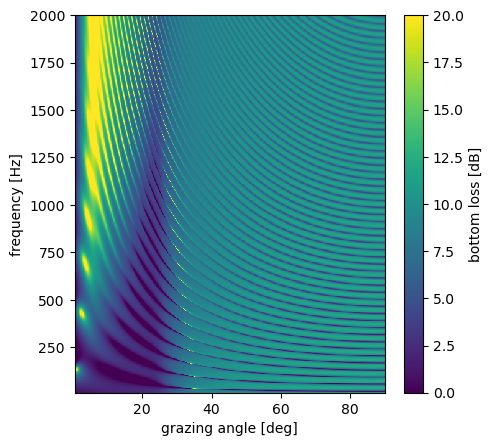

In [32]:
TH,F = meshgrid(theta1q2.real, freq, sparse=True)

plt.figure(figsize=(5, 5), dpi=100)
plt.pcolor(TH,F, bl)
plt.axis('tight')
plt.xlabel('grazing angle [deg]')
plt.ylabel('frequency [Hz]')
plt.colorbar(label='bottom loss [dB]')
plt.clim(0,20)

plt.show()

### a)

We plot some low frequency behaviors to compare with the half space with sand bottom from question 1. 

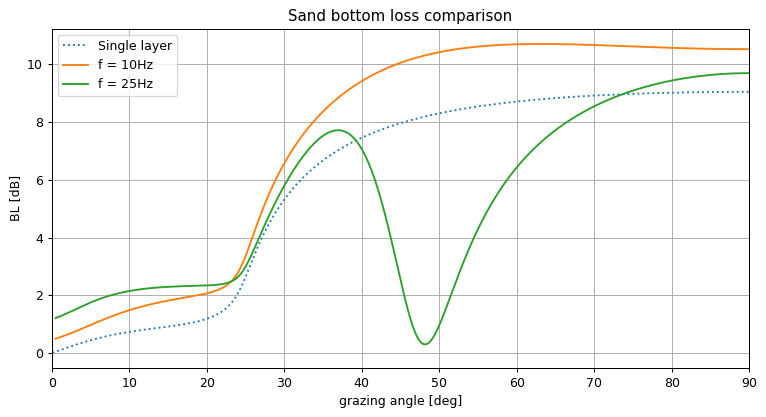

In [33]:
plt.figure(figsize=(10, 5), dpi=90)

plt.plot(theta1.real, BL(abs(r['sand'])), ls=':', label='Single layer')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 10)) ), \
                        label='f = 10Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 25)) ), \
                        label='f = 25Hz')

plt.xlim([0,90])
plt.ylabel('BL [dB]')
plt.xlabel('grazing angle [deg]')
plt.grid()
plt.legend()
plt.title('Sand bottom loss comparison')
plt.show()

At lower frequencies, we see bottom loss act as if there was no middle layer of clay. When $f=10$ Hz, the real part of $\phi_2$ remains below unity, $0 < \Re\{\phi_2\} < 1$. This eliminates  the oscillatory behaviour of the reflection coefficient since we will never pass a vertical discontinuity in $\tan(\phi_2)$. This can be seen by the lack of resonant peaks in the bottom loss at $f=10$Hz shown above. 

As $\tan(\phi_2) \rightarrow 0$, the relfection coefficient looses dependence of $Z_2$. At $\tan(\phi_2) = 0$,

$
    R = \frac{Z_3-Z_1}{Z_3+Z_1},
$

Which will exactly equal the single layer water and sand result, thus eliminating effects of the layer in this problem.

In [16]:
thetalist = linspace(0.5,90., 10,dtype=complex) # [deg]
for theta in thetalist:
    theta2=( Theta2(df.loc['water','cc'],df.loc['clay','cc'],theta) )
    print( phi(10,df.loc['clay','cc'].real,h2,theta2))

(0.09838142385235156+0.013070474044117892j)
(0.18046242978799718+0.006891894696947482j)
(0.30765894469656135+0.003672578931370492j)
(0.43412718847127124+0.002206706927213515j)
(0.5502653818501329+0.0013602612775453907j)
(0.6511440041306166+0.0008084716355577526j)
(0.7332100692779311+0.0004340683460860017j)
(0.7937659810767058+0.00018750225663352382j)
(0.8308790421155149+4.615834025938349e-05j)
(0.843380578144911+5.755467736057478e-36j)


### b)

We plot some low frequency behaviors to compare with the half space with clay bottom from question 1. Recall, clay does not have a critical angle but does have an angle of intromission at $6^\circ$.

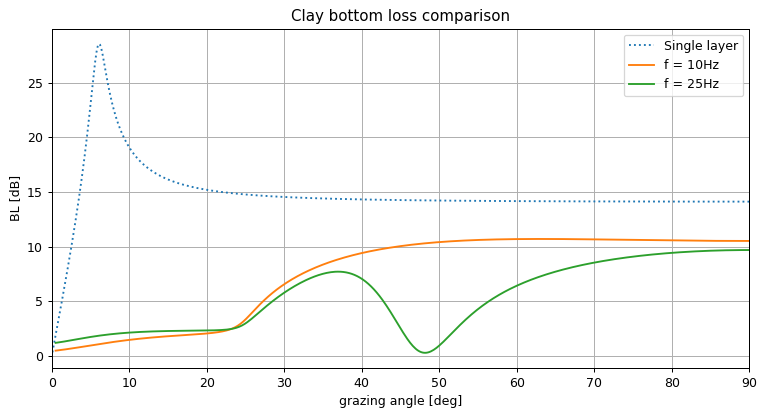

In [17]:
plt.figure(figsize=(10, 5), dpi=90)

plt.plot(theta1.real, BL(abs(r['clay'])), ls=':', label='Single layer')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 10)) ), \
                        label='f = 10Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 25)) ), \
                        label='f = 25Hz')

plt.xlim([0,90])
plt.ylabel('BL [dB]')
plt.xlabel('grazing angle [deg]')
plt.grid()
plt.legend()
plt.title('Clay bottom loss comparison')
plt.show()

At lower frequencies, we see bottom loss act as if there was no middle layer of clay. We see this by the dissimilarity between bottom loss of the layered model with the single layer of clay. The discussion in part **a** supports this claim. 

### c)

Here we look at the importance of the layer at low and high frequencies

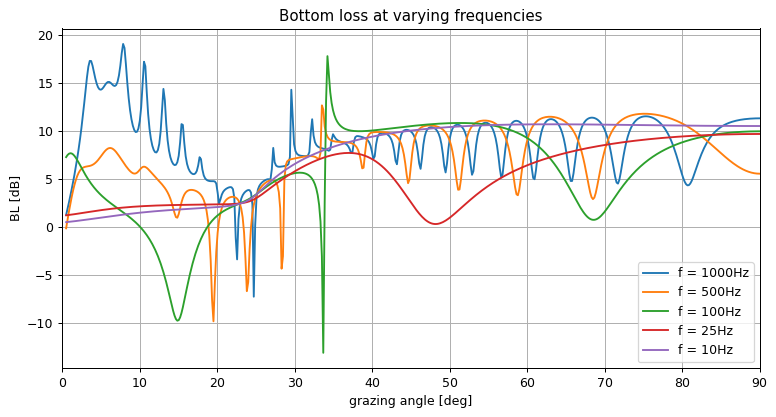

In [18]:
plt.figure(figsize=(10, 5), dpi=90)

plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 1000)) ), \
                        label='f = 1000Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 500)) ), \
                        label='f = 500Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 100)) ), \
                        label='f = 100Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 25)) ), \
                        label='f = 25Hz')
plt.plot(theta1q2.real, BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, theta1q2, 10)) ), \
                        label='f = 10Hz')
plt.xlim([0,90])
plt.ylabel('BL [dB]')
plt.xlabel('grazing angle [deg]')
plt.grid()
plt.legend()
plt.title('Bottom loss at varying frequencies')
plt.show()

Follwing the discussion in parts **a** and **b**, we see that the middle layer of clay does not contribute strongly to the reflection coefficient at low frequencies. 

As the frequency increases, the middle layer begins to dominate contributions to the reflection coefficient. Although the relfection coefficient oscillates as a function of the phase delay $\phi_2$, we can generally see the curve at $f=1000$ Hz resemble the single layer clay bottom loss. This line captures the angle of intromission produced by the clay layer.

As frequency increases, $\phi_2$ also increases which will contribute to higher magnitudes of the relfection coefficient close to the system's critical angle, $\|R\|$ increases as $\theta_i \rightarrow \theta_c$.

In [19]:
thetalist2 = linspace(0.5,90., 1000,dtype=complex) # [deg]
for theta in thetalist:
    theta2=( Theta2(df.loc['water','cc'],df.loc['clay','cc'],theta) )
    print( phi(1000,df.loc['clay','cc'].real,h2,theta2))

(9.838142385235153+1.307047404411789j)
(18.046242978799715+0.689189469694748j)
(30.76589446965613+0.36725789313704915j)
(43.41271884712712+0.22067069272135145j)
(55.02653818501328+0.13602612775453907j)
(65.11440041306165+0.08084716355577524j)
(73.32100692779309+0.04340683460860016j)
(79.37659810767057+0.01875022566335238j)
(83.08790421155147+0.004615834025938349j)
(84.33805781449108+5.755467736057478e-34j)


In [20]:
thetacR12 = thetac(df.loc['water','cc'],df.loc['clay','cc'])
thetacR13 = thetac(df.loc['water','cc'],df.loc['sand','cc'])

print('For R12, theta_c = %0.4f deg. This doesnt exist since c1>c2,\nFor R13, theta_c = %0.4f.' \
      %(thetacR12.real,thetacR13.real) )

For R12, theta_c = 0.9026 deg. This doesnt exist since c1>c2,
For R13, theta_c = 24.7101.


In [21]:
BL(abs(Rlayered (df, 'water', 'clay', 'sand',\
                                 h2, thetalist2, 1000)) )
# 40.03088213
thetalist2[35]

(3.6356356356356354+0j)

We find the critical angle at $1000$ Hz is approximately $3.635^\circ$ which provides a resonant peak in bottom loss close to $\theta_I$ of the single clay layer. 

We conclude that as frequency increses, the middle layer influences the total bottom loss more.

### d)

Here we examine the frequency dependence of bottom loss at normal incidence. At normal incidence $\theta_1 = \theta_2 = \theta_3 = \pi/2$. We calculate $h_2 = (2m-1)(\lambda_2/a)$ for $m \in \mathcal{N}$ where $a$ indicates the wavelength fraction of interest ($a=2$ for half wavelength). 


First we find the 1/4 and 1/2 wavelength layers within the frequency range displayed, $10$ to $2000$ Hz.

In [22]:
def layerFrequencies(m,c,h, wl='quarter'):
    frequency = c*(2.*m-1)/(4.*h)
    if (wl == 'half'):
        return frequency*2.
    return frequency

We record frequencies for half and quarter wavelength layers for the first 27 modes.

In [23]:
m = arange(27)+1
modes = pd.DataFrame(columns=['mode','half','quarter'])
modes['mode'] = m
modes['half'] = layerFrequencies(m,df.loc['clay','c'],h2,'half')
modes['quarter'] = layerFrequencies(m,df.loc['clay','c'],h2)
modes= modes.set_index('mode')

modes

,half,quarter
mode,,
1,37.25,18.625
2,111.75,55.875
3,186.25,93.125
4,260.75,130.375
5,335.25,167.625
6,409.75,204.875
7,484.25,242.125
8,558.75,279.375
9,633.25,316.625


Now, we take a closer look at the first few layers by zooming into the bottom loss calculated at the beginning of solution 2. We limit ouselves to visualizing a freqeuncy range from $10$ to $240$ Hz. 

We also look at the last few layers in the range of $1740$ to $2000$ Hz.

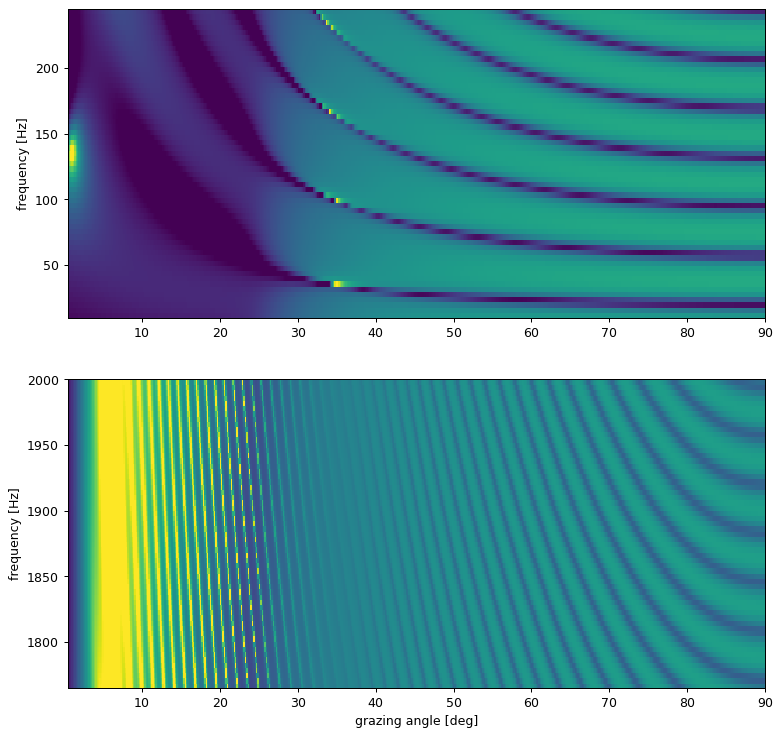

In [34]:
plt.figure(figsize=(10, 10), dpi=90)
plt.subplot(2,1,1)
plt.pcolor(TH,F[:60], bl[:60])
plt.ylabel('frequency [Hz]')
plt.clim(0,20)

plt.subplot(2,1,2)
plt.pcolor(TH,F[-60:], bl[-60:])
plt.xlabel('grazing angle [deg]')
plt.ylabel('frequency [Hz]')
plt.clim(0,20)

plt.show()

At normal incidence, we see a pattern in bottom loss at the half and quarter wavelength layers.

At each quarter layer frequency, the bottom loss is maximized after passing the critical grazing angle of $25^\circ$ and holds until reaching the normal incidence, $90^\circ$.

The half wavelength layers minimize bottom loss. This results from eliminating impedance due to the clay middle layer for all grazing angles.

<sub>Written by I. Escobar on 09 September 2020</sub>